Import required packages

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy import distance
import folium
import requests
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Import Foursquare credentials from json file created to preserve secrecy and store in global variables CLIENT_ID and CLIENT_SECRET

In [2]:
import json
globals().update(json.loads(open("foursquareCredentials.json", "r") .read()))
VERSION = '20181124' # Foursquare API version

Get longitude and latitude of location

In [3]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode("Rumbach Sebestyén u., Budapest, 1075 Hungary")
location = geolocator.geocode("Galley Ave, Toronto")
lat = location.latitude
long = location.longitude

Define function degreeLen which for a given lat and long returns the length of a degree of lat and long in km

In [4]:
def degreeLen(lat, long):
    """Returns the lengths of a single degree of latitude and longitude in km for a given latitude and longitude
    """
    # get length of 1 degree at current latidude and logitude
    latDegree = distance.distance((lat - 0.5, long), (lat + 0.5, long)).km
    longDegree = distance.distance((lat, long - 0.5), (lat, long + 0.5)).km
    return latDegree, longDegree
degreeLen(lat, long)

(111.10526895049591, 80.68550614496871)

Define function grid that returns the set of grid points within a circle around location.  Grid points are a distance tick apart.

In [5]:
def grid(lat, long, radius, tick):
    """Returns a set whose elements are a grid of points within a circle around a location
    :param lat: latitude of centre of grid
    :param long: longitude of centre of grid
    :param radius: radius of grid in km
    :param tick: distance between points in grid in km
    """
    # get length of 1 degree at current latidude and logitude
    latDegree, longDegree = degreeLen(lat, long)
    
    # get length of 1 tick in degrees
    latTick = tick / latDegree
    longTick = tick / longDegree
    
    # get coordinates of point which is one radius to the South and West of (lat, long)
    bottomLeft = (lat - radius / latDegree, long - radius / longDegree)
    
    # get tick points along axis
    gridLats = np.arange(2 * radius / tick + 1) * latTick + bottomLeft[0]
    gridLongs = np.arange(2 * radius / tick + 1) * longTick + bottomLeft[1]
    
    # initialise set grid
    grid = set()
    
    # populate set grid
    for lt in gridLats:
        [grid.add((lt, lg)) for lg in gridLongs if distance.distance((lat, long), (lt, lg)).km <= radius]
        
    return grid

Check grid function is working using Folium

In [6]:
g = grid(lat, long, 2, 0.2)
# create map
map_grid = folium.Map(location=[lat, long], zoom_start=13)

for (lt, lg) in g:
    folium.CircleMarker([lt, lg],
                        radius=2,
                        fill=True,
                        fill_opacity=0.5).add_to(map_grid)
       
map_grid

In [7]:
len(g)

310

Define function for pulling list of nearby venues, with optional filter on category Id

In [8]:
def getNearbyVenues(lat, long, radius, categoryId = ''):
    url = ('https://api.foursquare.com/v2/venues/search?' +
            '&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION) +
            '&intent=browse&ll={},{}&radius={}&categoryId={}'.format(lat, long, radius, categoryId))
    
    venues = requests.get(url).json()['response']['venues']
    venues_list=[]
    
    for v in venues:
        if len(v['categories']) > 0:
            venues_list.append([v['id'], v['name'], v['location']['distance'], v['categories'][0]['name']])
        else:
            venues_list.append([v['id'], v['name'], v['location']['distance'], 'None'])
    
    return(venues_list)

Check function getNearbyVenues is working

In [9]:
categoryId = '4bf58dd8d48988d16d941735'
radius = 200
getNearbyVenues(lat, long, radius, categoryId)

[['4aeb7a91f964a5207dc221e3', 'La la Bistro', 109, 'Café']]

Define function targetDensity which outputs a measure the density of a list of venues within a specific radius of a location.
The density measure has the property of being larger the more venues there are in the list and the closer they are.
So for each venue we subtract the distance from the radius so that a venue in the centre of the circle adds the radius distance to the density measure while a venue on the edge of the circle adds 0 to the density measure.

In [10]:
def targetDensity(venues, radius):
    distances = []
    [distances.append(radius/(v[2] + 1)) for v in venues if v[2] <= radius]
    return np.sum(np.asarray(distances))
targetDensity(getNearbyVenues(lat, long, radius, categoryId), radius)

1.8181818181818181

In [11]:
# Check if density for empty list of venues = 0
targetDensity([], radius)

0.0

In [12]:
targets = []
ids = set()
for (lt, lg) in g:
    print((lt, lg))
    venues = getNearbyVenues(lt, lg, radius, categoryId)
    density = targetDensity(venues, radius)
    targets.append((lt, lg, density))
    for (v_id, name, distance, category) in venues:
        ids.add(v_id)

(43.626467448168185, -79.4533327198708)
(43.6426683, -79.46076899967701)
(43.6426683, -79.42854512051676)
(43.64446839464797, -79.4533327198708)
(43.64626848929595, -79.47068403941864)
(43.65346886788787, -79.4533327198708)
(43.63726801605606, -79.46572651954783)
(43.63726801605606, -79.43350264038757)
(43.63906811070404, -79.46076899967701)
(43.63906811070404, -79.42854512051676)
(43.64806858394393, -79.46076899967701)
(43.64806858394393, -79.42854512051676)
(43.651668773239884, -79.44093892019379)
(43.657069057183826, -79.46076899967701)
(43.6336678267601, -79.46820527948323)
(43.6336678267601, -79.43598140032297)
(43.63546792140808, -79.44589644006459)
(43.626467448168185, -79.44589644006459)
(43.6426683, -79.46820527948323)
(43.6426683, -79.43598140032297)
(43.64446839464797, -79.44589644006459)
(43.64626848929595, -79.4508539599354)
(43.65346886788787, -79.44589644006459)
(43.65526896253584, -79.4508539599354)
(43.630067637464144, -79.46324775961243)
(43.62826754281617, -79.458290

(43.651668773239884, -79.42854512051676)
(43.64626848929595, -79.43350264038757)
(43.626467448168185, -79.45829023974161)
(43.63546792140808, -79.42606636058136)
(43.64446839464797, -79.45829023974161)
(43.64446839464797, -79.42606636058136)
(43.64626848929595, -79.46324775961243)
(43.65346886788787, -79.45829023974161)
(43.65526896253584, -79.46324775961243)
(43.630067637464144, -79.4533327198708)
(43.63186773211212, -79.45829023974161)
(43.63726801605606, -79.47068403941864)
(43.63906811070404, -79.4533327198708)
(43.640868205352014, -79.45829023974161)
(43.640868205352014, -79.42606636058136)
(43.64806858394393, -79.4533327198708)
(43.64986867859191, -79.45829023974161)
(43.64986867859191, -79.42606636058136)
(43.651668773239884, -79.46324775961243)
(43.6588691518318, -79.45581147980621)
(43.65526896253584, -79.46572651954783)
(43.626467448168185, -79.4508539599354)
(43.6426683, -79.43102388045216)
(43.64446839464797, -79.4508539599354)
(43.64626848929595, -79.44589644006459)
(43.65

In [13]:
targetsDf = pd.DataFrame(targets)
targetsDf.columns = ['Latitude', 'Longitude', 'Density']
targetsDf.set_index(['Latitude', 'Longitude'], inplace=True)
targetsDf.sort_index(inplace=True)
targetsDf

Density
Latitude  Longitude            
43.624667 -79.448375   0.000000
43.626467 -79.458290   0.000000
          -79.455811   0.000000
          -79.453333   0.000000
          -79.450854   0.000000
          -79.448375   0.000000
          -79.445896   0.000000
          -79.443418   0.000000
          -79.440939   0.000000
          -79.438460   0.000000
43.628268 -79.460769   0.000000
          -79.458290   0.000000
          -79.455811   0.000000
          -79.453333   0.000000
          -79.450854   0.000000
          -79.448375   0.000000
          -79.445896   0.000000
          -79.443418   0.000000
          -79.440939   0.000000
          -79.438460   0.000000
          -79.435981   0.000000
43.630068 -79.465727   0.000000
          -79.463248   0.000000
          -79.460769   0.000000
          -79.458290   0.000000
          -79.455811   0.000000
          -79.453333   0.000000
          -79.450854   0.000000
          -79.448375   0.000000
          -79.445896   0.000000
...                         ...
43.655269 -79.448375   1.005025
          -79.445896   0.000000
          -79.443418   0.000000
          -79.440939   0.000000
          -79.438460   0.000000
          -79.435981   0.000000
          -79.433503   0.000000
          -79.431024   0.000000
43.657069 -79.463248   0.000000
          -79.460769   0.000000
          -79.458290   0.000000
          -79.455811   0.000000
          -79.453333   1.298701
          -79.450854   0.000000
          -79.448375   8.347826
          -79.445896   2.548184
          -79.443418   2.100099
          -79.440939   3.340593
          -79.438460   0.000000
          -79.435981   0.000000
          -79.433503   0.000000
43.658869 -79.458290   0.000000
          -79.455811   0.000000
          -79.453333   3.333333
          -79.450854   1.142857
          -79.448375   2.097921
          -79.445896   2.105263
          -79.443418   9.291423
          -79.440939  13.794961
          -79.438460  12.929758

[310 rows x 1 columns]

In [14]:
targetsDf.describe()

,Density
count,310.000000
mean,1.075627
std,3.049879
min,0.000000
25%,0.000000
50%,0.000000
75%,1.072409
max,31.054263


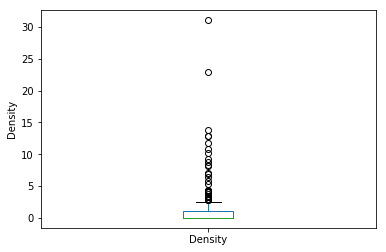

In [15]:
targetsDf.plot(y='Density', kind='box')
plt.ylabel('Density')
plt.show()

In [16]:
targetsDf['Density Log'] = np.log10(targetsDf['Density'].values + 1)

In [17]:
targetsDf.describe()

,Density,Density Log
count,310.000000,310.000000
mean,1.075627,0.160204
std,3.049879,0.296747
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.072409,0.316474
max,31.054263,1.505886


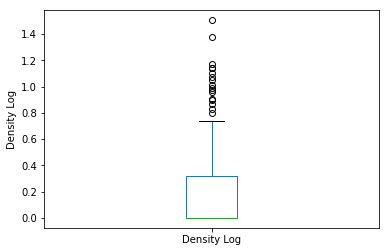

In [18]:
targetsDf.plot(y='Density Log', kind='box')
plt.ylabel('Density Log')
plt.show()

In [19]:
ids

{'4ad4c05df964a52035f620e3',
 '4ada24e2f964a5200d1f21e3',
 '4addf4e4f964a520bd6621e3',
 '4aeb7a91f964a5207dc221e3',
 '4aec5216f964a52009c621e3',
 '4b00ae1ef964a5208e4022e3',
 '4b51d0b5f964a520925627e3',
 '4b64d9def964a520edd42ae3',
 '4ba52185f964a5206fe138e3',
 '4bde066ee75c0f47779cc603',
 '4beb39fb61aca593e2cf8400',
 '4bf95e8f5efe2d7ffa126c34',
 '4c76c323f2473704eff663eb',
 '4c94f2a072dd224bc1c49e91',
 '4cb20412562d224b587c2388',
 '4cc45537c844721e6994e801',
 '4cd57e5cab19a09300813feb',
 '4cdeecddf8a4a14330b8dabc',
 '4cfa84442d80a143413d45d8',
 '4d74f5bed238a1cdcc71dd0e',
 '4dd6a8c2fa76ad96d1115c08',
 '4e90d802cc2127f5dabb9821',
 '4eeb4a51be7be63d1dff0d26',
 '4f5cbe6fe4b01219ac4fbaff',
 '4f5f4d39e4b0b79c8255f6ce',
 '4f9ec309e4b02343ca272ba8',
 '4ffdf93b45b0986b7d20c825',
 '5005ece0e4b0d23ce4803e7c',
 '5013037be4b0ad6ab2229394',
 '50744ea8498e74a4f695c7d9',
 '50f0b424e4b0599e42e31047',
 '5137b53ce4b071af38d34174',
 '517c906be4b0a6c18b46b608',
 '51a94bf9498eb42cf80aec74',
 '51fe8468498e

In [20]:
otherVenues = []
for (lt, lg) in g:
    print((lt, lg))
    venues = getNearbyVenues(lt, lg, radius)
    for (v_id, name, distance, category) in venues:
        if not (v_id in ids) and category != 'None':
            otherVenues.append((lt, lg, v_id, name, distance, category))

(43.626467448168185, -79.4533327198708)
(43.6426683, -79.46076899967701)
(43.6426683, -79.42854512051676)
(43.64446839464797, -79.4533327198708)
(43.64626848929595, -79.47068403941864)
(43.65346886788787, -79.4533327198708)
(43.63726801605606, -79.46572651954783)
(43.63726801605606, -79.43350264038757)
(43.63906811070404, -79.46076899967701)
(43.63906811070404, -79.42854512051676)
(43.64806858394393, -79.46076899967701)
(43.64806858394393, -79.42854512051676)
(43.651668773239884, -79.44093892019379)
(43.657069057183826, -79.46076899967701)
(43.6336678267601, -79.46820527948323)
(43.6336678267601, -79.43598140032297)
(43.63546792140808, -79.44589644006459)
(43.626467448168185, -79.44589644006459)
(43.6426683, -79.46820527948323)
(43.6426683, -79.43598140032297)
(43.64446839464797, -79.44589644006459)
(43.64626848929595, -79.4508539599354)
(43.65346886788787, -79.44589644006459)
(43.65526896253584, -79.4508539599354)
(43.630067637464144, -79.46324775961243)
(43.62826754281617, -79.458290

(43.651668773239884, -79.42854512051676)
(43.64626848929595, -79.43350264038757)
(43.626467448168185, -79.45829023974161)
(43.63546792140808, -79.42606636058136)
(43.64446839464797, -79.45829023974161)
(43.64446839464797, -79.42606636058136)
(43.64626848929595, -79.46324775961243)
(43.65346886788787, -79.45829023974161)
(43.65526896253584, -79.46324775961243)
(43.630067637464144, -79.4533327198708)
(43.63186773211212, -79.45829023974161)
(43.63726801605606, -79.47068403941864)
(43.63906811070404, -79.4533327198708)
(43.640868205352014, -79.45829023974161)
(43.640868205352014, -79.42606636058136)
(43.64806858394393, -79.4533327198708)
(43.64986867859191, -79.45829023974161)
(43.64986867859191, -79.42606636058136)
(43.651668773239884, -79.46324775961243)
(43.6588691518318, -79.45581147980621)
(43.65526896253584, -79.46572651954783)
(43.626467448168185, -79.4508539599354)
(43.6426683, -79.43102388045216)
(43.64446839464797, -79.4508539599354)
(43.64626848929595, -79.44589644006459)
(43.65

In [21]:
otherVenuesDf = pd.DataFrame(otherVenues)
otherVenuesDf.columns = ['Latitude', 'Longitude', 'VenueID', 'Name', 'Distance', 'Category']
otherVenuesDf.set_index(['Latitude', 'Longitude'], inplace=True)
otherVenuesDf.sort_index(inplace=True)
otherVenuesDf

VenueID  \
Latitude  Longitude                              
43.630068 -79.433503  4c05add75753c928c7e139f1   
          -79.431024  4c05add75753c928c7e139f1   
43.631868 -79.438460  4bf5b46c94b2a593b123acee   
          -79.438460  508d22aae4b0b69fe8dcced1   
          -79.438460  524829c911d21c70ea429391   
          -79.435981  4bd621807b1876b0da118c86   
          -79.435981  4bf97b08328d76b0b39c14ec   
          -79.435981  508d22aae4b0b69fe8dcced1   
          -79.435981  524829c911d21c70ea429391   
          -79.435981  4f8ec263e4b018d8f68e6253   
          -79.433503  4c05add75753c928c7e139f1   
          -79.433503  4bf97b08328d76b0b39c14ec   
          -79.433503  4bd621807b1876b0da118c86   
          -79.433503  4b93312ff964a520633a34e3   
          -79.433503  51ade51d498e158483637c84   
          -79.433503  4dbdfcc85da3ff58ec70e830   
          -79.431024  4c05add75753c928c7e139f1   
          -79.431024  4c9154081adc37048d332fd1   
          -79.431024  4db6b1fd4b226b343db90cc7   
          -79.431024  4f87b123e4b0a95f9249e452   
          -79.431024  51ade51d498e158483637c84   
43.633668 -79.468205  4c6208cbfa7bc92895620d27   
          -79.468205  4b93eb6ff964a520d15934e3   
          -79.468205  5238ea57498ef96b339a9e40   
          -79.468205  4d0f54a559606dcb43ec6d3e   
          -79.468205  4c8ba1993dc2a1cdb6e5b732   
          -79.465727  4c6208cbfa7bc92895620d27   
          -79.465727  4c2949159fb5d13a5cfb9a57   
          -79.465727  4df4f8e0c65bf55ee530e59f   
          -79.455811  4cd5ceada5b346886e509050   
...                                        ...   
43.658869 -79.440939  4bb1ea67f964a52073aa3ce3   
          -79.440939  4b8168c7f964a52055a430e3   
          -79.440939  4b217ce9f964a520a63c24e3   
          -79.440939  4be993704f5576b04c0ab396   
          -79.438460  4adb4489f964a520642521e3   
          -79.438460  4dceadb4d22deadedd58116d   
          -79.438460  539df284498e79c67475ac1c   
          -79.438460  4aff507ef964a520443722e3   
          -79.438460  4ae62455f964a52006a521e3   
          -79.438460  4d4f544fbd6ff04dddc2dc0c   
          -79.438460  4adcd2a6f964a5203c3021e3   
          -79.438460  4b217ce9f964a520a63c24e3   
          -79.438460  4b8216c4f964a5203dca30e3   
          -79.438460  4e0611fdaeb74c3991076117   
          -79.438460  4bb14d50f964a520cb8a3ce3   
          -79.438460  55208e01498e31eeac5ff582   
          -79.438460  59e43422e4c459524afcfb17   
          -79.438460  5b53497346e1b6002c9f798d   
          -79.438460  4ce829a9f1c6236a021e5ef0   
          -79.438460  4eb4ea68e5e874370504af98   
          -79.438460  55f83d41498e0c712ef3a194   
          -79.438460  507990dce4b08ac08df130ac   
          -79.438460  4d928a95b32737044c128525   
          -79.438460  4b7f4c73f964a520db2530e3   
          -79.438460  4fc41012e4b0988ab4268eca   
          -79.438460  584f2380ae97563cef971650   
          -79.438460  59668f3160d11b0ba1b697fa   
          -79.438460  4d8d10b65234a09043ceabbd   
          -79.438460  4cacfd40f47ea1435f189621   
          -79.438460  54b0637b498e961bab949e92   

                                                              Name  Distance  \
Latitude  Longitude                                                            
43.630068 -79.433503                             Marilyn Bell Park       106   
          -79.431024                             Marilyn Bell Park       238   
43.631868 -79.438460           Toronto Sailing & Canoe Club (TSCC)       218   
          -79.438460                             Frostbite Regatta       143   
          -79.438460                              Lush Head Office       197   
          -79.435981                          Argonaut Rowing Club        20   
          -79.435981                      Gardiner Expy at Jameson       220   
          -79.435981                             Frostbite Regatta        96   
          -79.435981                              Lush Head Office       156   
        

In [22]:
otherVenuesDf['Density'] = radius/(otherVenuesDf['Distance'].values + 1) 

In [23]:
otherVenuesDf.groupby(['Latitude', 'Longitude', 'Category'])['Density'].sum().to_frame()

Density
Latitude  Longitude  Category                                           
43.630068 -79.433503 Park                                       1.869159
          -79.431024 Park                                       0.836820
43.631868 -79.438460 Athletics & Sports                         1.388889
                     Harbor / Marina                            0.913242
                     Tech Startup                               1.010101
          -79.435981 Athletics & Sports                         2.061856
                     Building                                   1.098901
                     Gym / Fitness Center                       9.523810
                     Road                                       0.904977
                     Tech Startup                               1.273885
          -79.433503 Convenience Store                          1.980198
                     Gym / Fitness Center                       0.966184
                     Moving Target                              1.025641
                     Park                                       2.061856
                     Road                                       2.168479
          -79.431024 Convenience Store                          0.975610
                     Moving Target                              2.597403
                     Park                                       0.851064
                     Residential Building (Apartment / Condo)   1.242236
                     Road                                       1.600000
43.633668 -79.468205 Bus Line                                   1.680672
                     Dog Run                                    4.255319
                     Park                                       0.643087
                     Sculpture Garden                           1.081081
                     Trail                                      0.800000
          -79.465727 American Restaurant                        1.086957
                     Dessert Shop                               1.015228
                     Trail                                      0.704225
          -79.455811 Residence                                  1.219512
          -79.445896 Bus Line                                   1.020408
...                                                                  ...
43.658869 -79.440939 Mexican Restaurant                        11.764706
                     Neighborhood                               1.204819
                     Office                                     1.010101
                     Salon / Barbershop                        17.320261
                     Strip Club                                 3.333333
                     Thrift / Vintage Store                     5.263158
                     Vietnamese Restaurant                      5.128205
          -79.438460 Bakery                                     1.754386
                     Bar                                        6.971538
                     Beer Bar                                   2.272727
                     Bike Shop                                  6.906643
                     Cocktail Bar                               2.941176
                     Flower Shop                                3.125000
                     Furniture / Home Store                     5.555556
                     Gift Shop                                  2.985075
                     Grocery Store                              1.226994
                     High School                                1.869159
                     Music Store                                4.444444
                     Neighborhood                               4.081633
                     Office                                     4.651163
                     Park                                       1.739130
                     Pet Service                                2.702703
                     Pet Store                    

In [24]:
features = pd.pivot_table(otherVenuesDf,index=['Latitude', 'Longitude'],values='Density',
                          columns='Category',aggfunc=[np.sum],fill_value=0)['sum']

In [25]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 250 entries, (43.630067637464144, -79.43350264038757) to (43.6588691518318, -79.43846016025837)
Columns: 321 entries, Accessories Store to Zoo Exhibit
dtypes: float64(320), int64(1)
memory usage: 627.8 KB


In [26]:
features

Category              Accessories Store  Advertising Agency  \
Latitude  Longitude                                           
43.630068 -79.433503           0.000000            0.000000   
          -79.431024           0.000000            0.000000   
43.631868 -79.438460           0.000000            0.000000   
          -79.435981           0.000000            0.000000   
          -79.433503           0.000000            0.000000   
          -79.431024           0.000000            0.000000   
43.633668 -79.468205           0.000000            0.000000   
          -79.465727           0.000000            0.000000   
          -79.455811           0.000000            0.000000   
          -79.445896           0.000000            0.000000   
          -79.440939           0.000000            0.000000   
          -79.438460           0.000000            0.000000   
          -79.435981           0.000000            0.000000   
          -79.433503           0.000000            0.000000   
          -79.431024           0.000000            0.000000   
          -79.428545           0.000000            0.000000   
43.635468 -79.470684           0.000000            0.000000   
          -79.468205           0.000000            0.000000   
          -79.465727           0.000000            0.000000   
          -79.463248           0.000000            0.000000   
          -79.460769           0.000000            0.000000   
          -79.458290           0.000000            0.000000   
          -79.453333           0.000000            0.000000   
          -79.450854           0.000000            0.000000   
          -79.448375           0.000000            0.000000   
          -79.445896           0.000000            0.000000   
          -79.443418           0.000000            0.000000   
          -79.440939           0.000000            0.000000   
          -79.438460           0.000000            0.000000   
          -79.435981           0.000000            0.000000   
...                                 ...                 ...   
43.655269 -79.448375           0.000000            0.000000   
          -79.445896           0.000000            0.000000   
          -79.443418           0.000000            1.626016   
          -79.440939           0.000000            1.176471   
          -79.438460           0.000000            0.000000   
          -79.435981          26.017316            0.000000   
          -79.433503           1.360544            0.000000   
          -79.431024           0.000000            0.000000   
43.657069 -79.463248           0.000000            0.000000   
          -79.460769           0.000000            0.000000   
          -79.458290           0.000000            0.000000   
          -79.455811           0.000000            0.000000   
          -79.453333           0.000000            0.000000   
          -79.450854           0.000000            0.000000   
          -79.448375           0.000000            0.000000   
          -79.445896           0.000000            0.000000   
          -79.443418           0.000000            0.000000   
          -79.440939           0.000000            0.000000   
          -79.438460           1.081081            0.000000   
          -79.435981          12.500000            0.000000   
          -79.433503           0.000000            0.000000   
43.658869 -79.458290           0.000000            0.000000   
          -79.455811           0.000000            0.000000   
          -79.453333           0.000000            0.000000   
          -79.450854           0.000000            0.000000   
          -79.448375           0.000000            0.000000   
          -79.445896           0.000000            0.000000   
          -79.443418           0.000000            0.000000   
          -79.440939           0.000000            0.000000   
          -79.438460           0.000000            0.000000   

Category              African 

In [27]:
features.describe()

Category,Accessories Store,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Vietnamese Restaurant,Warehouse,Water Park,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.174936,0.050708,0.028132,0.114291,0.026815,0.248389,0.730210,0.023036,0.109621,0.040262,...,0.207246,0.023096,0.004124,0.046526,0.023022,0.020554,0.140477,0.073982,0.015269,0.022563
std,1.828668,0.347899,0.320804,0.725684,0.316229,1.352668,2.255420,0.185381,0.548129,0.482619,...,1.012055,0.186714,0.065202,0.291973,0.225916,0.198243,0.717945,0.622185,0.155466,0.220218
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,26.017316,4.347826,4.255319,9.307359,4.494112,14.263844,24.264706,1.851852,4.449254,7.407407,...,8.937965,1.941748,1.030928,2.597403,2.898551,2.564103,9.251559,9.090909,2.173913,2.898551


In [28]:
features = np.log10(features + 1)

In [29]:
features.describe()

Category,Accessories Store,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Vietnamese Restaurant,Warehouse,Water Park,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.015991,0.011939,0.005191,0.021787,0.004985,0.040538,0.115205,0.006140,0.023645,0.006636,...,0.035497,0.006140,0.001231,0.011602,0.005393,0.005082,0.030098,0.013796,0.004090,0.005357
std,0.123386,0.073729,0.058279,0.110805,0.056602,0.157937,0.259544,0.048764,0.109969,0.066876,...,0.150606,0.048854,0.019460,0.070401,0.050710,0.047272,0.120052,0.088877,0.039225,0.050034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.431642,0.728177,0.720599,1.013147,0.739898,1.183664,1.402514,0.455127,0.736337,0.924662,...,0.997297,0.468605,0.307694,0.555989,0.590903,0.551950,1.010790,1.003930,0.501595,0.590903


In [30]:
features = features.join(targetsDf).fillna(0).reset_index()

In [31]:
features.describe()

,Latitude,Longitude,Accessories Store,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,...,Water Park,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Density,Density Log
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,43.645383,-79.447483,0.015991,0.011939,0.005191,0.021787,0.004985,0.040538,0.115205,0.006140,...,0.001231,0.011602,0.005393,0.005082,0.030098,0.013796,0.004090,0.005357,1.333777,0.198653
std,0.007491,0.012888,0.123386,0.073729,0.058279,0.110805,0.056602,0.157937,0.259544,0.048764,...,0.019460,0.070401,0.050710,0.047272,0.120052,0.088877,0.039225,0.050034,3.346260,0.318762
min,43.630068,-79.470684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.639068,-79.458290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43.644468,-79.445896,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,43.651669,-79.435981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.290482,0.359918
max,43.658869,-79.426066,1.431642,0.728177,0.720599,1.013147,0.739898,1.183664,1.402514,0.455127,...,0.307694,0.555989,0.590903,0.551950,1.010790,1.003930,0.501595,0.590903,31.054263,1.505886


In [32]:
X = features.drop(['Latitude', 'Longitude', 'Density', 'Density Log'], axis=1)
y = features['Density Log']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=22)

In [34]:
reg_all = linear_model.LinearRegression()
reg_all.fit(X_train, y_train)
y_pred_test = reg_all.predict(X_test)
y_pred_train = reg_all.predict(X_train)
reg_all.score(X_test, y_test)

-2.564611345862272e+21

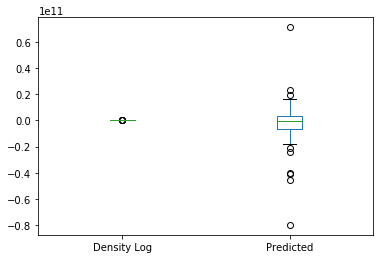

In [35]:
testDf = y_test.to_frame()
testDf['Predicted'] = y_pred_test
testDf.plot(kind='box')
plt.show()

In [36]:
testDf.describe()

,Density Log,Predicted
count,75.000000,7.500000e+01
mean,0.222026,-2.926911e+09
std,0.342311,1.708307e+10
min,0.000000,-7.999400e+10
25%,0.000000,-6.232371e+09
50%,0.000000,-4.905071e+08
75%,0.418722,3.423921e+09
max,1.379413,7.132595e+10


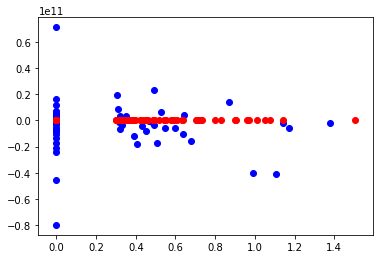

In [37]:
plt.scatter(y_test, y_pred_test, color='blue')
plt.scatter(y_train, y_pred_train, color='red')
plt.show()

In [38]:
lasso = linear_model.Lasso(alpha=0.005, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred_test = lasso.predict(X_test)
lasso_pred_train = lasso.predict(X_train)
lasso.score(X_test, y_test)

0.1736294603080012

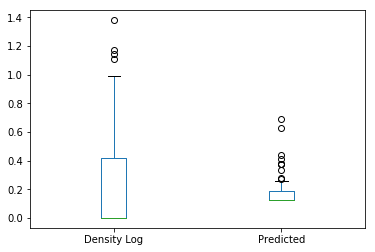

In [39]:
testDf = y_test.to_frame()
testDf['Predicted'] = lasso_pred_test
testDf.plot(kind='box')
plt.show()

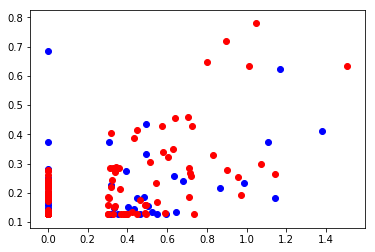

In [40]:
plt.scatter(y_test, lasso_pred_test, color='blue')
plt.scatter(y_train, lasso_pred_train, color='red')
plt.show()

In [41]:
lasso_pred_all = lasso.predict(X)

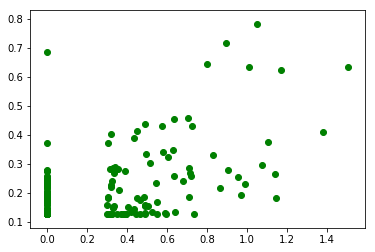

In [42]:
plt.scatter(y, lasso_pred_all, color='green')
plt.show()

In [43]:
len(lasso_pred_all)

250

In [44]:
results = features[['Latitude', 'Longitude', 'Density Log']]

In [45]:
results['Predicted'] = lasso_pred_all

C:\Users\mattc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


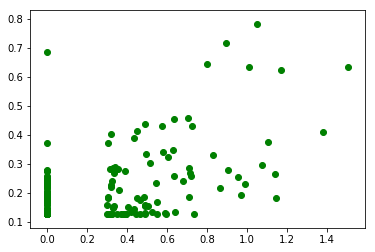

In [46]:
plt.scatter(results['Density Log'], results['Predicted'], color='green')
plt.show()

In [47]:
results['Rank'] = results['Predicted'] / (results['Density Log'] + 1)

C:\Users\mattc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
top10 = results.sort_values(by='Rank', ascending=False).head(10)
top10

,Latitude,Longitude,Density Log,Predicted,Rank
71,43.639068,-79.426066,0.000000,0.686923,0.686923
178,43.649869,-79.431024,1.049613,0.781657,0.381368
64,43.639068,-79.443418,0.897437,0.718035,0.378423
161,43.648069,-79.426066,0.000000,0.373796,0.373796
212,43.653469,-79.428545,0.799349,0.646208,0.359134
247,43.658869,-79.443418,1.012475,0.635156,0.315609
82,43.640868,-79.443418,0.319513,0.404702,0.306705
236,43.657069,-79.443418,0.491376,0.436335,0.292572
248,43.658869,-79.440939,1.170114,0.624006,0.287545
191,43.651669,-79.438460,0.306562,0.373900,0.286170


In [49]:
l = list(zip(top10['Latitude'], top10['Longitude']))
l

[(43.63906811070404, -79.42606636058136),
 (43.64986867859191, -79.43102388045216),
 (43.63906811070404, -79.44341768012919),
 (43.64806858394393, -79.42606636058136),
 (43.65346886788787, -79.42854512051676),
 (43.6588691518318, -79.44341768012919),
 (43.640868205352014, -79.44341768012919),
 (43.657069057183826, -79.44341768012919),
 (43.6588691518318, -79.44093892019379),
 (43.651668773239884, -79.43846016025837)]

In [50]:
# create map
map_grid = folium.Map(location=[lat, long], zoom_start=13)

for (lt, lg) in l:
    folium.CircleMarker([lt, lg],
                        radius=4,
                        fill=True,
                        fill_opacity=0.5,
                        color='Red').add_to(map_grid)
       
map_grid